## 1. Packages

In [13]:
using Random
using Statistics
using Plots

## 2. Helper - hypothesis updating



In [14]:
# true positive
function bayes_positive(prob_true::Float64,
    power::Float64,
    alpha::Float64)
    num = power * prob_true
    den = num + alpha * (1 - prob_true)
    return num / den
end


bayes_positive (generic function with 1 method)

In [15]:
# false negative 
function bayes_negative(prob_true::Float64,
    power::Float64,
    alpha::Float64)
    num = (1 - power) * prob_true
    den = num + (1 - alpha) * (1 - prob_true)
    return num / den
end


bayes_negative (generic function with 1 method)

## 3. Publication bias mechanism



In [ ]:
# false positive always publish
function update_false_with_pub(prob_true::Float64,
    power::Float64,
    alpha::Float64,
    pub_bias::Float64)
    if rand() < alpha

        return bayes_positive(prob_true, power, alpha)
    else
        # true negative
        if rand() < (1 - pub_bias)
            # published null
            return bayes_negative(prob_true, power, alpha)
        else
            # unpublished null
            return prob_true
        end
    end
end

# true positive always publish
function update_true_with_pub(prob_true,
    power,
    alpha,
    pub_bias)

    if rand() < power
        return bayes_positive(prob_true, power, alpha)
    else
        # false negative
        if rand() < (1 - pub_bias)
            # published null
            return bayes_negative(prob_true, power, alpha)
        else
            # unpublished null
            return prob_true
        end
    end
end

function update_with_pub(prob_true,
    true_hypothesis::Bool,
    power,
    alpha,
    pub_bias)
    # check if the hypothesis is true or false then update the probability based on the publication bias
    return true_hypothesis ?
           update_true_with_pub(prob_true, power, alpha, pub_bias) :
           update_false_with_pub(prob_true, power, alpha, pub_bias)
end


update_with_pub (generic function with 1 method)

## 4. Canonization dynamics


In [ ]:
function run_canonization(initial_prior,
    true_hypothesis,
    power,
    alpha,
    pub_bias,
    tau;
    max_steps::Int=10000)

    prob_true = initial_prior

    for _ in 1:max_steps
        # check if it hits a boundary
        if prob_true >= tau
            return true
        elseif prob_true <= 1 - tau
            return false
        end
        # update the probability with publication bias
        prob_true = update_with_pub(prob_true, true_hypothesis, power, alpha, pub_bias)
    end

    # if it reaches max steps without hitting a boundary return false
    return false
end

# same as run_canonization but also returns the traj of probabilities
function run_canonization_traj(initial_prior,
    true_hypothesis,
    power,
    alpha,
    pub_bias,
    tau;
    max_steps::Int=10000)

    prob_true = initial_prior
    traj = Float64[prob_true]

    for _ in 1:max_steps
        if prob_true >= tau
            return traj, true
        elseif prob_true <= 1 - tau
            return traj, false
        end

        prob_true = update_with_pub(prob_true, true_hypothesis, power, alpha, pub_bias)
        push!(traj, prob_true)
    end

    return traj, false
end


run_canonization_traj (generic function with 1 method)

## 5. Parameter sweep and simulate

In [18]:
# Simulation parameters
initial_prior = 0.5
powers = [0.8, 0.6]
taus = [0.9, 0.999]
alphas = [0.05, 0.10, 0.15, 0.20, 0.25]
pub_biases = collect(0.0:0.02:1.0)

n_runs = 1000

results = Dict{Tuple{Float64,Float64,Float64},Vector{Float64}}()

# Run simulations 
for power in powers
    for tau in taus
        for alpha in alphas
            probs = Float64[]
            for ρ in pub_biases
                count_true = 0
                for _ in 1:n_runs
                    # hypothesis is false  
                    if run_canonization(initial_prior, false, power, alpha, ρ, tau)
                        count_true += 1
                    end
                end
                push!(probs, count_true / n_runs)
            end
            results[(power, tau, alpha)] = probs
        end
    end
end


## 6. Build and display plot

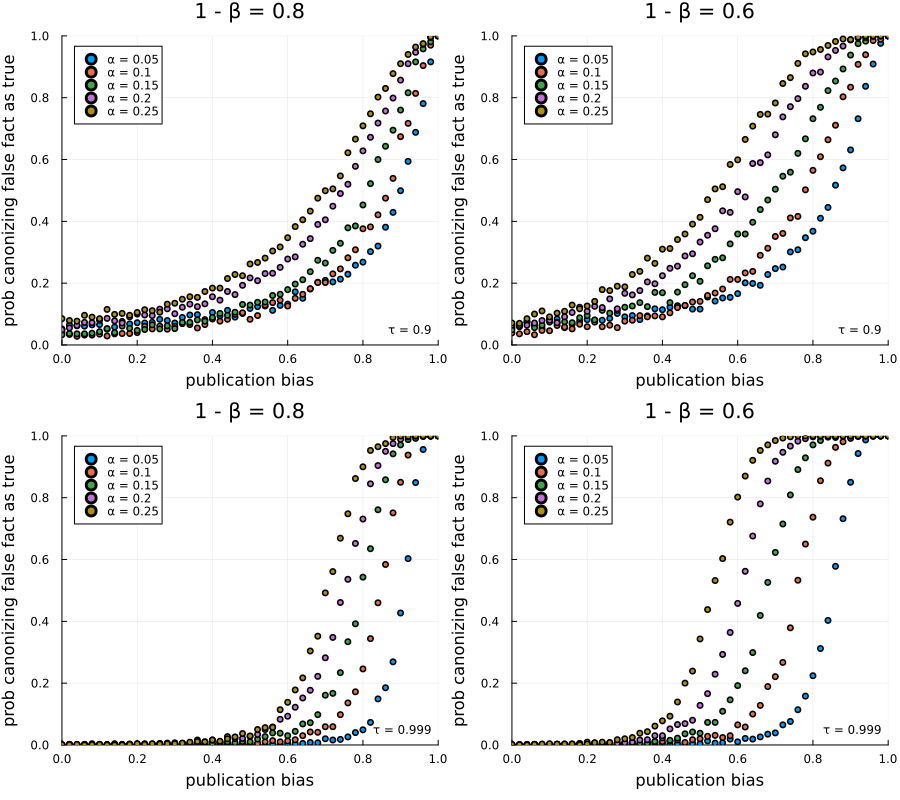

In [ ]:
function panel_plot(power, tau;
    alphas=alphas, pub_biases=pub_biases)

    plt = plot(
        xlabel="publication bias",
        ylabel="prob canonizing false fact as true",
        title="1 - β = $(power)",
        xlim=(0, 1),
        ylim=(0, 1),
        legend=:topleft,
    )

    for alpha in alphas
        y = results[(power, tau, alpha)]
        plot!(pub_biases, y;
            seriestype=:scatter,
            markersize=3,
            label="α = $(alpha)")
    end


    annotate!(0.98, 0.05, text("τ = $(tau)", :right, 8))

    return plt
end

p1 = panel_plot(0.8, 0.9) 
p2 = panel_plot(0.6, 0.9)
p3 = panel_plot(0.8, 0.999)
p4 = panel_plot(0.6, 0.999)

final_plot = plot(p1, p2, p3, p4, layout=(2, 2), size=(900, 800))

display(final_plot)


## 7. Single-run trajectory

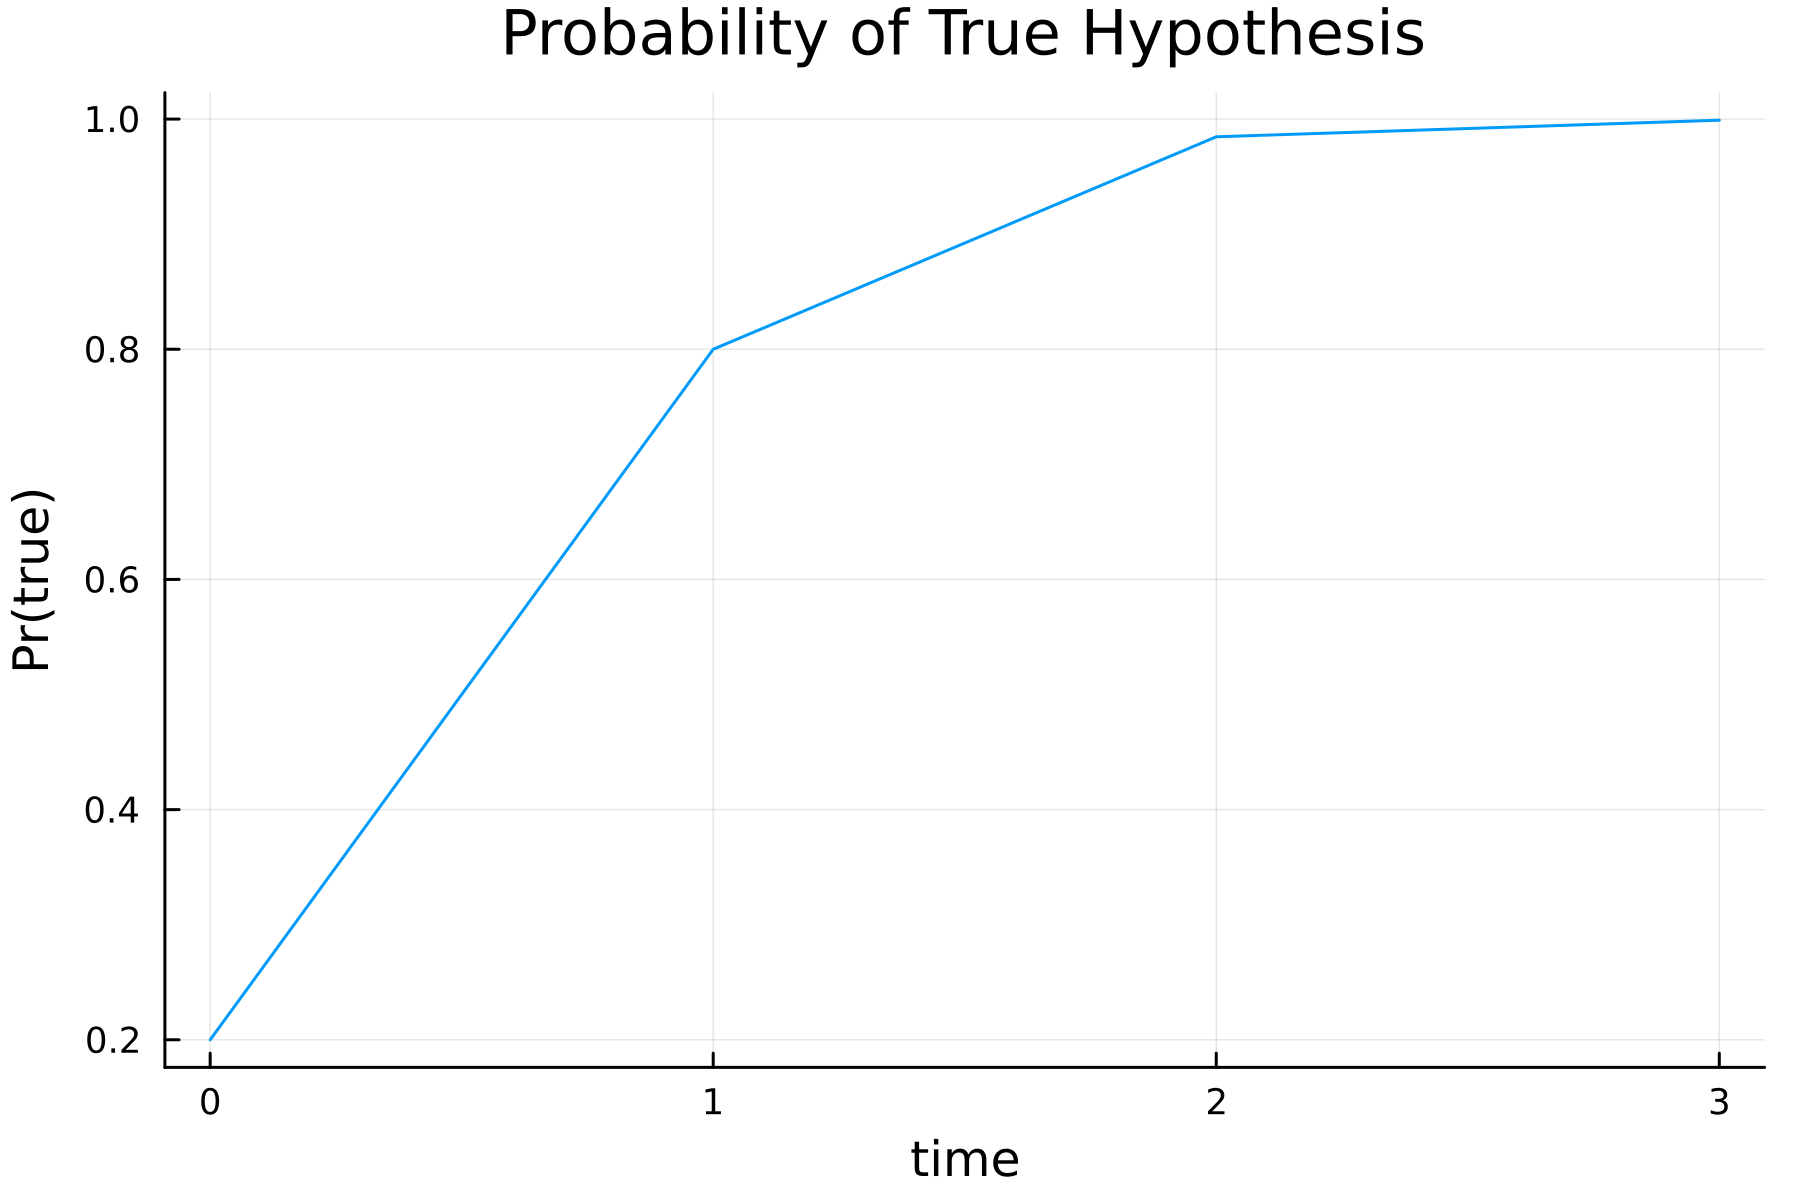

Canonized as true?  true


In [ ]:
# Simulate one run and plot - adjust parameters as needed

initial_prior = 0.2    # initial Pr(true)
true_hypothesis = true   # 
power = 0.8    # 1 - β
false_positive_rate = 0.05   # α
pub_bias = 0.2    # ρ
canonization_threshold = 0.99   # τ
max_steps = 200

traj, canonized_true = run_canonization_traj(
    initial_prior,
    true_hypothesis,
    power,
    false_positive_rate,
    pub_bias,
    canonization_threshold;
    max_steps=max_steps,
)

times = 0:(length(traj)-1)

plt = plot(
    times,
    traj,
    title="Probability of True Hypothesis",
    xlabel="time",
    ylabel="Pr(true)",
    legend=false,
    dpi=300,
)

display(plt)

println("Canonized as true?  ", canonized_true)